In [1]:
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

import fiona  # type: ignore
from fiona.crs import from_epsg # type: ignore
import geopandas as gpd  # type: ignore
import shapely # type: ignore
from shapely.geometry import Point

import matplotlib.pyplot as plt  # type: ignore
import seaborn as sns  # type: ignore


%matplotlib inline

In [2]:
#Read EstSoil-EH

estsoil_12c = "Data\\updated_sample_source_data\\updated_soc_source\\sql_transfer_estsoil_eh_12c_ndvi_geol.fgb"
data = gpd.read_file(estsoil_12c,encoding='utf-8')
display(data.head())

,orig_fid,est_soiltype,wrb_code,wrb_main,est_txcode,nlayers,zmx,z1,est_txt1,lxtype1,...,water_pct,area_other,other_pct,varv,kkt,ndvi_mean,ndvi_median,ndvi_stdev,geol_kivim,geometry
0,415405,LG,PZ-cb.ab.gl,PZ,l100,1.0,1000.0,1000.0,l,S,...,0.000000,0.000000,0.000000,9,KR,0.899488,0.908776,0.033655,None,"MULTIPOLYGON (((700666.080 6380328.780, 700678..."
1,488739,LkI,RT-ab.dy,RT,l200,1.0,2000.0,2000.0,l,S,...,0.000000,0.000000,0.000000,1,JK,0.799791,0.857820,0.179295,mergel,"MULTIPOLYGON (((700672.470 6380343.110, 700668..."
2,126206,GI,GL-eu-lv,GL,sl50/ls₂,2.0,1000.0,500.0,sl,LS,...,0.070688,1055.025875,1.061237,14,TA,0.731221,0.846522,0.214172,mergel,"MULTIPOLYGON (((700727.900 6380023.890, 700699..."
3,499116,LkI,RT-ab.dy,RT,l200,1.0,2000.0,2000.0,l,S,...,0.000000,0.000000,0.000000,1,JK,0.883113,0.885041,0.014856,mergel,"MULTIPOLYGON (((700523.870 6380688.330, 700517..."
4,719585,M''',HS-sa,HS,t₃150,1.0,1500.0,1500.0,t3,PEAT,...,0.000000,6.463670,0.044238,17,SS,0.876797,0.880973,0.021626,mergel,"MULTIPOLYGON (((700511.620 6380925.410, 700516..."


In [3]:
#Drop soc1 soc2 soc3 soc4 values
no_soc_data = data.drop(["soc1","soc2","soc3","soc4"],axis=1)
no_soc_data.columns

Index(['orig_fid', 'est_soiltype', 'wrb_code', 'wrb_main', 'est_txcode',
       'nlayers', 'zmx', 'z1', 'est_txt1', 'lxtype1', 'est_crs1', 'sand1',
       'silt1', 'clay1', 'rock1', 'bd1', 'k1', 'awc1', 'z2', 'est_txt2',
       'lxtype2', 'est_crs2', 'sand2', 'silt2', 'clay2', 'rock2', 'bd2', 'k2',
       'awc2', 'z3', 'est_txt3', 'lxtype3', 'est_crs3', 'sand3', 'silt3',
       'clay3', 'rock3', 'bd3', 'k3', 'awc3', 'z4', 'est_txt4', 'lxtype4',
       'est_crs4', 'sand4', 'silt4', 'clay4', 'rock4', 'bd4', 'k4', 'awc4',
       'unit_area', 'tri_mean', 'tri_stdev', 'tri_median', 'twi_mean',
       'twi_stdev', 'twi_median', 'slp_mean', 'slp_stdev', 'slp_median',
       'ls_mean', 'ls_stdev', 'ls_median', 'area_drain', 'drain_pct',
       'area_arable', 'arable_pct', 'area_forest', 'forest_pct',
       'area_grassland', 'grassland_pct', 'area_wetland', 'wetland_pct',
       'area_urban', 'urban_pct', 'area_water', 'water_pct', 'area_other',
       'other_pct', 'varv', 'kkt', 'ndvi_mean', 

In [4]:
#Drop all unnecessary columns(ones which are calculated based on previous SOC data and the ones which are already exist in soc_samples data)
#before joining to soc_samples data


sorted_data = no_soc_data.drop(['wrb_code',  'est_crs1', 'bd1', 'est_txt2', 'lxtype2', 
                    'est_crs2','bd2','k2','est_txt3', 'lxtype3', 'est_crs3', 'bd3', 'k3', 'est_txt4','lxtype4','est_crs4',
                       'bd4', 'k4','unit_area',  
                            'z2', 'sand2', 'clay2',
                                'rock2', 'z3', 'sand3', 'silt3','clay3','rock3','z4','sand4','awc2', 'awc3', 'awc4',
                               'silt4','clay4','rock4','silt2'],axis=1)
                                
#editing typos in column names
sorted_data.rename(columns={'wetland_pc' : 'wetland_pct', 'area_wetla' : 'area_wetland', 'grassland_' : 'grassland_pct', 
                            'area_arabl' : 'area_arable', 'area_fores':'area_forest','area_grass': 'area_grassland' }, inplace=True)                                
                                
                        

sorted_data.head()



,orig_fid,est_soiltype,wrb_main,est_txcode,nlayers,zmx,z1,est_txt1,lxtype1,sand1,...,water_pct,area_other,other_pct,varv,kkt,ndvi_mean,ndvi_median,ndvi_stdev,geol_kivim,geometry
0,415405,LG,PZ,l100,1.0,1000.0,1000.0,l,S,90,...,0.000000,0.000000,0.000000,9,KR,0.899488,0.908776,0.033655,None,"MULTIPOLYGON (((700666.080 6380328.780, 700678..."
1,488739,LkI,RT,l200,1.0,2000.0,2000.0,l,S,90,...,0.000000,0.000000,0.000000,1,JK,0.799791,0.857820,0.179295,mergel,"MULTIPOLYGON (((700672.470 6380343.110, 700668..."
2,126206,GI,GL,sl50/ls₂,2.0,1000.0,500.0,sl,LS,82,...,0.070688,1055.025875,1.061237,14,TA,0.731221,0.846522,0.214172,mergel,"MULTIPOLYGON (((700727.900 6380023.890, 700699..."
3,499116,LkI,RT,l200,1.0,2000.0,2000.0,l,S,90,...,0.000000,0.000000,0.000000,1,JK,0.883113,0.885041,0.014856,mergel,"MULTIPOLYGON (((700523.870 6380688.330, 700517..."
4,719585,M''',HS,t₃150,1.0,1500.0,1500.0,t3,PEAT,15,...,0.000000,6.463670,0.044238,17,SS,0.876797,0.880973,0.021626,mergel,"MULTIPOLYGON (((700511.620 6380925.410, 700516..."


In [5]:
sorted_data.isnull().sum()

orig_fid               0
est_soiltype           0
wrb_main               0
est_txcode             0
nlayers                0
zmx                    0
z1                     0
est_txt1               0
lxtype1                0
sand1                  0
silt1                  0
clay1                  0
rock1                  0
k1                     0
awc1                 482
tri_mean              99
tri_stdev             99
tri_median            99
twi_mean              99
twi_stdev             99
twi_median            99
slp_mean              95
slp_stdev             95
slp_median            95
ls_mean             7948
ls_stdev            1210
ls_median           7948
area_drain        476573
drain_pct         476573
area_arable            0
arable_pct             0
area_forest            0
forest_pct             0
area_grassland         0
grassland_pct          0
area_wetland           0
wetland_pct            0
area_urban             0
urban_pct              0
area_water             0


In [6]:
sorted_data["area_drain"] = sorted_data["area_drain"].fillna(0)  #fill with zero

sorted_data["drain_pct"] = sorted_data["drain_pct"].fillna(0) #fill with zero

In [7]:
processed_data = sorted_data.dropna(subset=["awc1", "tri_mean", "tri_stdev","twi_mean","twi_stdev",
                                   "slp_median","ls_mean", "ls_stdev", "ls_median","tri_median","geol_kivim"])


In [8]:
processed_data.isnull().sum()


orig_fid          0
est_soiltype      0
wrb_main          0
est_txcode        0
nlayers           0
zmx               0
z1                0
est_txt1          0
lxtype1           0
sand1             0
silt1             0
clay1             0
rock1             0
k1                0
awc1              0
tri_mean          0
tri_stdev         0
tri_median        0
twi_mean          0
twi_stdev         0
twi_median        0
slp_mean          0
slp_stdev         0
slp_median        0
ls_mean           0
ls_stdev          0
ls_median         0
area_drain        0
drain_pct         0
area_arable       0
arable_pct        0
area_forest       0
forest_pct        0
area_grassland    0
grassland_pct     0
area_wetland      0
wetland_pct       0
area_urban        0
urban_pct         0
area_water        0
water_pct         0
area_other        0
other_pct         0
varv              0
kkt               0
ndvi_mean         0
ndvi_median       0
ndvi_stdev        0
geol_kivim        0
geometry          0


In [9]:
processed_data.shape

(737190, 50)

In [10]:
# read soc data
soc_samples = gpd.read_file('Data\\updated_sample_source_data\\updated_soc_samples\\soc_rf_redone_3301_plus_plus.gpkg', layer = "soc_train_samples_outrem_origfid_avg_plus")
soc_samples.head()

,SOC_mean,origin,geol_kivim,ndvi,orig_fid,est_soiltype,wrb_code,wrb_main,est_txcode,nlayers,...,area_wetland,wetland_pct,area_urban,urban_pct,area_water,water_pct,area_other,other_pct,varv,geometry
0,11.078491,estonian_alvars_soil_sample_single_dataset.shp,lubjakivi,0.833887,15159.0,ArG,FL-gl.wso,FL,k⁰₃ls₁,1.0,...,14651.735166,16.460368,0.000000,0.000000,1061.431376,1.192456,20363.430457,22.877123,15.0,POINT (443390.670 6494246.123)
1,1.056000,envir_biosoils_survey.shp,liivakivi,0.853924,22283.0,D,UM-dl.hp,UM,l,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.0,POINT (661204.025 6433312.518)
2,5.339205,rmk_soil_data.shp,liivakivi,0.875607,45116.0,Dg,UM-dl.gln,UM,sl,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.0,POINT (593729.152 6457480.739)
3,1.000000,envir_kese_muld_export.shp,liivakivi,0.831588,86756.0,E2o,RG-br.eu,RG,v⁰₁ls,1.0,...,0.000000,0.000000,3034.647721,4.891685,0.000000,0.000000,526.615939,0.848876,18.0,POINT (644275.296 6425833.836)
4,4.029763,estonian_alvars_open_areas.shp,lubjakivi,0.698610,94817.0,Gh',LP-li.ca-gl,LP,r₃sl,1.0,...,0.000000,0.000000,127.390969,0.035944,939.938384,0.265209,149612.185454,42.213987,13.0,POINT (376404.901 6468198.723)


In [11]:
list(soc_samples.columns)

['SOC_mean',
 'origin',
 'geol_kivim',
 'ndvi',
 'orig_fid',
 'est_soiltype',
 'wrb_code',
 'wrb_main',
 'est_txcode',
 'nlayers',
 'zmx',
 'z1',
 'est_txt1',
 'lxtype1',
 'est_crs1',
 'sand1',
 'silt1',
 'clay1',
 'rock1',
 'awc1',
 'unit_area',
 'tri_mean',
 'tri_stdev',
 'tri_median',
 'twi_mean',
 'twi_stdev',
 'twi_median',
 'slp_mean',
 'slp_stdev',
 'slp_median',
 'ls_mean',
 'ls_stdev',
 'ls_median',
 'area_drain',
 'drain_pct',
 'area_arable',
 'arable_pct',
 'area_forest',
 'forest_pct',
 'area_grassland',
 'grassland_pct',
 'area_wetland',
 'wetland_pct',
 'area_urban',
 'urban_pct',
 'area_water',
 'water_pct',
 'area_other',
 'other_pct',
 'varv',
 'geometry']

In [12]:
soc_samples = soc_samples.drop([
 'origin',
 'geol_kivim',
 'ndvi',
 'est_soiltype',
 'wrb_code',
 'wrb_main',
 'est_txcode',
 'nlayers',
 'zmx',
 'z1',
 'est_txt1',
 'lxtype1',
 'est_crs1',
 'sand1',
 'silt1',
 'clay1',
 'rock1',
 'awc1',
 'unit_area',
 'tri_mean',
 'tri_stdev',
 'tri_median',
 'twi_mean',
 'twi_stdev',
 'twi_median',
 'slp_mean',
 'slp_stdev',
 'slp_median',
 'ls_mean',
 'ls_stdev',
 'ls_median',
 'area_drain',
 'drain_pct',
 'area_arable',
 'arable_pct',
 'area_forest',
 'forest_pct',
 'area_grassland',
 'grassland_pct',
 'area_wetland',
 'wetland_pct',
 'area_urban',
 'urban_pct',
 'area_water',
 'water_pct',
 'area_other',
 'other_pct',
 'varv',
 'geometry'
],axis=1)

In [13]:
soc_samples.columns

Index(['SOC_mean', 'orig_fid'], dtype='object')

In [14]:
#merge dataframes of Soc_samples file and Estsoil-EH
merged_data = pd.merge(processed_data, soc_samples, on= "orig_fid")
display(merged_data.sample(50))

,orig_fid,est_soiltype,wrb_main,est_txcode,nlayers,zmx,z1,est_txt1,lxtype1,sand1,...,area_other,other_pct,varv,kkt,ndvi_mean,ndvi_median,ndvi_stdev,geol_kivim,geometry,SOC_mean
122,545658,LP,UM,v⁰₂sl60-80/v⁰₁ls₁,2.0,1000.0,700.0,sl,LS,82,...,31135.263050,2.050824,6,JK,0.816064,0.868726,0.157076,liivakivi,"MULTIPOLYGON (((594940.760 6453165.860, 594974...",1.740000
21,409793,L(k)IIg,PZ,l60-90/s,2.0,1000.0,750.0,l,S,90,...,0.000000,0.000000,8,MS,0.838754,0.845537,0.059862,liivakivi,"MULTIPOLYGON (((683064.480 6415896.850, 683053...",4.292002
260,109034,GI,GL,v⁰₁l,1.0,1000.0,1000.0,l,S,90,...,0.000000,0.000000,14,TA,0.810807,0.871592,0.118967,liivakivi,"MULTIPOLYGON (((673581.170 6592084.670, 673584...",2.300000
336,141557,GI1,GL,pl30-70/tsl,2.0,1000.0,500.0,pl,S,90,...,14878.557393,2.338032,16,TR,0.864250,0.873253,0.045369,lubjakivi,"MULTIPOLYGON (((582932.330 6580878.370, 582934...",4.210000
30,638352,LPg,UM,v⁰₁sl60-70/v⁰₁ls₁,2.0,1000.0,650.0,sl,LS,82,...,510.768237,0.149879,7,JK,0.892753,0.906708,0.047058,liivakivi,"MULTIPOLYGON (((675151.100 6433341.190, 675152...",1.015694
502,377804,Kr,RG,kb₄l,1.0,1000.0,1000.0,l,S,90,...,0.000000,0.000000,2,SL,0.784383,0.787072,0.064859,mergel,"MULTIPOLYGON (((455196.350 6503240.860, 455191...",6.683101
125,734664,S'',HS,t₂60-90/ls₂,2.0,1000.0,750.0,t2,PEAT,20,...,0.000000,0.000000,11,MO,0.857163,0.868696,0.042611,liivakivi,"MULTIPOLYGON (((562023.250 6440816.130, 562004...",28.132251
53,563945,LP,UM,k⁰₁sl45/k⁰₁ls,2.0,1000.0,450.0,sl,LS,82,...,0.000000,0.000000,6,JK,0.915509,0.916515,0.011360,liivakivi,"MULTIPOLYGON (((651154.460 6418502.620, 651166...",1.490000
589,257757,Kg,RG,r₂ls₁30-80/p,2.0,1000.0,550.0,ls1,SL,65,...,155460.304247,11.776113,12,LU,0.782150,0.780201,0.055767,lubjakivi,"MULTIPOLYGON (((462261.970 6491190.430, 462259...",5.133411
89,567754,LP,UM,v⁰₁sl50-90/v⁰₁ls₂,2.0,1000.0,700.0,sl,LS,82,...,6770.102123,1.275682,6,JK,0.841507,0.881832,0.110829,liivakivi,"MULTIPOLYGON (((631297.550 6412605.710, 631299...",2.320000


In [15]:
list(merged_data.columns)

['orig_fid',
 'est_soiltype',
 'wrb_main',
 'est_txcode',
 'nlayers',
 'zmx',
 'z1',
 'est_txt1',
 'lxtype1',
 'sand1',
 'silt1',
 'clay1',
 'rock1',
 'k1',
 'awc1',
 'tri_mean',
 'tri_stdev',
 'tri_median',
 'twi_mean',
 'twi_stdev',
 'twi_median',
 'slp_mean',
 'slp_stdev',
 'slp_median',
 'ls_mean',
 'ls_stdev',
 'ls_median',
 'area_drain',
 'drain_pct',
 'area_arable',
 'arable_pct',
 'area_forest',
 'forest_pct',
 'area_grassland',
 'grassland_pct',
 'area_wetland',
 'wetland_pct',
 'area_urban',
 'urban_pct',
 'area_water',
 'water_pct',
 'area_other',
 'other_pct',
 'varv',
 'kkt',
 'ndvi_mean',
 'ndvi_median',
 'ndvi_stdev',
 'geol_kivim',
 'geometry',
 'SOC_mean']

In [16]:
#columns and their types
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
merged_data.dtypes


orig_fid             int64
est_soiltype        object
wrb_main            object
est_txcode          object
nlayers            float64
zmx                float64
z1                 float64
est_txt1            object
lxtype1             object
sand1                int64
silt1                int64
clay1                int64
rock1                int64
k1                 float64
awc1               float64
tri_mean           float64
tri_stdev          float64
tri_median         float64
twi_mean           float64
twi_stdev          float64
twi_median         float64
slp_mean           float64
slp_stdev          float64
slp_median         float64
ls_mean            float64
ls_stdev           float64
ls_median          float64
area_drain         float64
drain_pct          float64
area_arable        float64
arable_pct         float64
area_forest        float64
forest_pct         float64
area_grassland     float64
grassland_pct      float64
area_wetland       float64
wetland_pct        float64
a

In [17]:
processed_data_done = merged_data.drop([
    'orig_fid',
 'est_soiltype',
 'wrb_main',
 'est_txcode',
 'nlayers',
 'zmx',
 'z1',
 'est_txt1',
 'lxtype1',
 'k1',
 'awc1',
 'area_drain',
 'area_arable',
 'area_forest',
 'area_grassland',
 'area_wetland',
 'area_urban',
 'area_water',
 'area_other',
 'varv',
 'kkt',
 'geometry'

], axis=1)


In [18]:
processed_data_done.columns

Index(['sand1', 'silt1', 'clay1', 'rock1', 'tri_mean', 'tri_stdev',
       'tri_median', 'twi_mean', 'twi_stdev', 'twi_median', 'slp_mean',
       'slp_stdev', 'slp_median', 'ls_mean', 'ls_stdev', 'ls_median',
       'drain_pct', 'arable_pct', 'forest_pct', 'grassland_pct', 'wetland_pct',
       'urban_pct', 'water_pct', 'other_pct', 'ndvi_mean', 'ndvi_median',
       'ndvi_stdev', 'geol_kivim', 'SOC_mean'],
      dtype='object')

In [19]:
#making sure that neither categorical column left 
processed_data_done.select_dtypes(include=["object"])

,geol_kivim
0,mergel
1,lubjakivi
2,lubjakivi
3,lubjakivi
4,liivakivi
...,...
638,domeriit
639,liivakivi
640,liivakivi
641,mergel


In [20]:
# get dummies
dummy_processed_data = pd.get_dummies(processed_data_done, columns = ['geol_kivim'], drop_first=False)

In [21]:
dummy_processed_data.head()

,sand1,silt1,clay1,rock1,tri_mean,tri_stdev,tri_median,twi_mean,twi_stdev,twi_median,slp_mean,slp_stdev,slp_median,ls_mean,ls_stdev,ls_median,drain_pct,arable_pct,forest_pct,grassland_pct,wetland_pct,urban_pct,water_pct,other_pct,ndvi_mean,ndvi_median,ndvi_stdev,SOC_mean,geol_kivim_domeriit,geol_kivim_liivakivi,geol_kivim_lubjakivi,geol_kivim_mergel
0,82,9,9,0,0.231413,0.205858,0.145219,7.737550,7.541194,1.597936,3.331885,2.986755,2.243041,0.423486,0.268150,0.511595,0.0,0.0,89.777030,0.000000,2.915014,4.228541,0.0,3.079415,0.786717,0.828896,0.103493,0.745000,0,0,0,1
1,82,9,9,6,0.397224,0.377407,0.254694,6.815005,6.216774,2.364833,5.527063,5.153583,3.951139,0.499527,0.215892,0.627902,0.0,0.0,99.385245,0.000000,0.614755,0.000000,0.0,0.000000,0.812543,0.815715,0.031115,4.643895,0,0,1,0
2,82,9,9,0,0.175027,0.158588,0.092891,8.593580,8.302189,1.277187,2.394535,2.178245,1.493280,0.226761,0.209027,0.256147,0.0,0.0,93.264658,0.000000,6.735342,0.000000,0.0,0.000000,0.828076,0.830479,0.025756,4.057884,0,0,1,0
3,90,5,5,0,0.215046,0.180647,0.143486,8.175904,8.230142,1.416957,2.828344,2.341998,2.157688,0.212859,0.096345,0.321160,0.0,0.0,98.256998,0.000000,1.743002,0.000000,0.0,0.000000,0.815810,0.834382,0.073468,0.498000,0,0,1,0
4,90,5,5,0,0.150427,0.122780,0.098808,8.952388,8.923770,1.311548,1.911665,1.534368,1.361293,0.168850,0.113070,0.201751,0.0,0.0,95.096759,0.309807,2.196761,2.396673,0.0,0.000000,0.843153,0.842424,0.046747,3.747488,0,1,0,0


In [22]:
processed_data_done = dummy_processed_data

In [23]:
processed_data_done.shape

(643, 32)

In [24]:
#Splitting data for machine learning

y = np.array(processed_data_done['SOC_mean'])

x = processed_data_done.drop(['SOC_mean'], axis =1)


#Checking the shapes of data

print(f'x : {x.shape}')
print(f'y : {y.shape}')


x : (643, 31)
y : (643,)


In [25]:
#splitting data into test and train set
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.30, random_state = 101)

In [26]:
print(f'x_train : {x_train.shape}')
print(f'y_tain : {y_train.shape}')
print(f'x_test : {x_test.shape}')
print(f'y_test : {y_test.shape}')

x_train : (450, 31)
y_tain : (450,)
x_test : (193, 31)
y_test : (193,)


<h1> RFE <h1>

In [27]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor 
randomforest = RandomForestRegressor()

In [28]:
rfe_m = RFE(estimator=randomforest, step=1)
rfe_m = rfe_m.fit(x_train,y_train)

In [29]:
selected_rfe_features = pd.DataFrame({"Feature":list(x_train.columns),
                                     "Ranking": rfe_m.ranking_})
selected_rfe_features.sort_values(by="Ranking")

,Feature,Ranking
12,slp_median,1
20,wetland_pct,1
19,grassland_pct,1
18,forest_pct,1
17,arable_pct,1
16,drain_pct,1
25,ndvi_median,1
14,ls_stdev,1
13,ls_mean,1
11,slp_stdev,1


In [30]:
x_train_rfe = rfe_m.transform(x_train)
x_test_rfe = rfe_m.transform(x_test)

In [31]:
fin_rfe_model =  randomforest.fit(x_train_rfe,y_train)

In [32]:
#Accuracy of Basic Random Forest Model
print (f'Train Accuracy - : {randomforest.score(x_train_rfe,y_train):.3f}')
print (f'Test Accuracy - : {randomforest.score(x_test_rfe,y_test):.3f}')

Train Accuracy - : 0.947
Test Accuracy - : 0.524


 <h1>Training Model Evaluation<h1>

In [33]:
y_predict_train = fin_rfe_model.predict((x_train_rfe))

In [34]:
#Model Evaluation using R-Square for Random Forest Regression
from sklearn import metrics

r_square_train = metrics.r2_score(y_train, y_predict_train)
print('R-Square Error associated with Random Forest Regression is: %.2f'%r_square_train)

R-Square Error associated with Random Forest Regression is: 0.95


In [35]:
#Mean absolute error evaluation
from sklearn.metrics import mean_absolute_error

print("The MAE is: %.2f" % mean_absolute_error(y_train, y_predict_train)) 

The MAE is: 1.26


In [36]:
from sklearn.metrics import mean_squared_error
#Mean square error evaluation

print('Root Mean Squared Error associated with Random Forest Regression is: %.2f'%np.sqrt(mean_squared_error(y_train, y_predict_train)))

rmsep = np.sqrt(np.mean(np.square(((y_train - y_predict_train) / y_train)), axis=0)) 
print ( "Root Mean Squared Error in percentage: %.2f"% rmsep)

Root Mean Squared Error associated with Random Forest Regression is: 2.24
Root Mean Squared Error in percentage: 0.77


In [37]:
#Mean absolute error calculation
from sklearn.metrics import explained_variance_score

print("The EVS is: %.2f" % explained_variance_score(y_train, y_predict_train))  

The EVS is: 0.95


 <h1>Test Model Evaluation<h1>

In [38]:
y_predict_test = fin_rfe_model.predict(x_test_rfe)

In [39]:
#Model Evaluation using R-Square for Random Forest Regression

r_square = metrics.r2_score(y_test, y_predict_test)
print('R-Square Error associated with Random Forest Regression is: %.2f'%r_square)

R-Square Error associated with Random Forest Regression is: 0.52


In [40]:
#Mean absolute error evaluation

print("The MAE is: %.2f" % mean_absolute_error(y_test, y_predict_test))     

The MAE is: 3.01


In [41]:
#Mean square error evaluation

print('Root Mean Squared Error associated with Random Forest Regression is: %.2f'%np.sqrt(mean_squared_error(y_test, y_predict_test)))

rmsep = np.sqrt(np.mean(np.square(((y_test - y_predict_test) / y_test)), axis=0)) 
print ( "Root Mean Squared Error in percentage: %.2f"% rmsep)

Root Mean Squared Error associated with Random Forest Regression is: 5.71
Root Mean Squared Error in percentage: 2.53


In [42]:
#Mean absolute error calculation

print("The EVS is: %.2f" % explained_variance_score(y_test, y_predict_test))    

The EVS is: 0.53


In [43]:
import shap

# Fits the explainer
explainer = shap.Explainer(fin_rfe_model.predict, x_test_rfe)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_test_rfe)

Permutation explainer: 194it [01:20,  2.18it/s]                                                                        


<h1> SOC Residual Calculation <h1>

In [60]:
soc_sample_res =  processed_data_done[[
"slp_median",
"wetland_pct",
"grassland_pct",
"forest_pct",
"arable_pct",
"drain_pct",
"ndvi_median",
"ls_stdev",
"ls_mean",
"slp_stdev",
"ndvi_mean",
"tri_stdev",
"tri_mean",
"clay1",
"ndvi_stdev"
]]

In [61]:
res_processed_data_done =  processed_data_done

In [63]:
# running model on final data
val = soc_sample_res.values

display(val.shape)
Prediction = fin_rfe_model.predict(val)

res_processed_data_done['SOC_pred'] = Prediction

display(res_processed_data_done.sample(10))

(643, 15)

,sand1,silt1,clay1,rock1,tri_mean,tri_stdev,tri_median,twi_mean,twi_stdev,twi_median,slp_mean,slp_stdev,slp_median,ls_mean,ls_stdev,ls_median,drain_pct,arable_pct,forest_pct,grassland_pct,wetland_pct,urban_pct,water_pct,other_pct,ndvi_mean,ndvi_median,ndvi_stdev,SOC_mean,geol_kivim_domeriit,geol_kivim_liivakivi,geol_kivim_lubjakivi,geol_kivim_mergel,SOC_pred
623,90,5,5,6,0.073061,0.052673,0.073743,9.720774,9.796477,0.907775,0.678387,0.482252,0.683130,0.066027,0.050333,0.080752,31.023,0.000000,96.161495,1.797526,0.000000,0.108653,0.012150,1.925974,0.857909,0.886601,0.088911,2.790000,1,0,0,0,5.956186
569,55,30,15,15,0.068447,0.052876,0.051966,9.849512,9.901166,0.767205,0.726438,0.590392,0.545618,0.051144,0.000000,0.061481,0.000,21.764184,2.061538,61.096596,0.000000,15.077682,0.000000,0.000000,0.803634,0.814867,0.087888,6.150000,0,0,1,0,8.102618
148,65,20,15,6,0.111636,0.082494,0.109081,9.263277,9.294950,1.302631,1.588742,1.193778,1.518351,0.292651,0.184527,0.408882,69.240,71.661308,1.662800,10.215721,0.000000,9.179475,0.139909,7.985899,0.830406,0.860997,0.096088,2.280000,0,1,0,0,6.890728
587,65,20,15,15,0.117720,0.076198,0.133340,9.975538,10.157690,1.363087,1.385391,0.861917,1.683368,0.152637,0.084236,0.208407,0.000,0.000000,80.554540,7.167138,2.026315,1.785878,0.730599,7.772177,0.883468,0.897502,0.048523,3.619490,0,0,1,0,8.236664
24,82,9,9,0,0.123589,0.103636,0.080759,9.220132,9.417022,1.059098,1.456589,1.087332,1.262256,0.224503,0.131369,0.311895,0.000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.857506,0.849726,0.030900,3.060049,0,1,0,0,9.089632
257,90,3,7,0,0.169345,0.143492,0.104176,8.336902,8.382313,1.032475,1.957989,1.524585,1.554893,0.147124,0.000000,0.212590,0.000,0.000000,96.939646,0.000000,0.000000,0.000000,0.000000,3.060354,0.846284,0.852595,0.027944,7.310000,0,1,0,0,9.268455
258,90,3,7,0,0.101729,0.073442,0.077987,8.968645,9.059105,0.865177,1.160563,0.724145,1.107106,0.102319,0.070677,0.124547,0.000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.873747,0.876782,0.020646,2.145000,0,1,0,0,8.885367
163,82,9,9,0,0.087911,0.041928,0.122746,9.857191,10.148163,1.163345,0.765134,0.380338,1.089555,0.081305,0.058776,0.108107,100.000,0.000000,95.176185,0.000000,0.000000,0.000000,0.281212,4.542603,0.892815,0.916447,0.059693,6.648829,0,1,0,0,6.601626
297,65,20,15,15,0.084652,0.065546,0.064531,10.087652,10.297399,1.311711,1.238406,0.951018,0.999774,0.196197,0.132904,0.232527,0.000,94.573294,1.411582,2.209561,0.000000,1.805562,0.000000,0.000000,0.627575,0.655611,0.136598,1.522500,0,0,1,0,8.048921
600,25,25,50,0,0.048189,0.034838,0.061799,9.915161,10.000732,0.840714,0.425325,0.251190,0.724125,0.065009,0.000000,0.137070,0.030,0.001230,1.528080,0.000000,98.188712,0.005323,0.256351,0.020304,0.594655,0.590835,0.092829,29.466357,0,0,1,0,9.127825


In [64]:
#calculating residuals
res_processed_data_done['SOC_res'] = res_processed_data_done['SOC_mean'] - res_processed_data_done['SOC_pred']

In [65]:
res_processed_data_done

,sand1,silt1,clay1,rock1,tri_mean,tri_stdev,tri_median,twi_mean,twi_stdev,twi_median,slp_mean,slp_stdev,slp_median,ls_mean,ls_stdev,ls_median,drain_pct,arable_pct,forest_pct,grassland_pct,wetland_pct,urban_pct,water_pct,other_pct,ndvi_mean,ndvi_median,ndvi_stdev,SOC_mean,geol_kivim_domeriit,geol_kivim_liivakivi,geol_kivim_lubjakivi,geol_kivim_mergel,SOC_pred,SOC_res
0,82,9,9,0,0.231413,0.205858,0.145219,7.737550,7.541194,1.597936,3.331885,2.986755,2.243041,0.423486,0.268150,0.511595,0.000,0.000000,89.777030,0.000000,2.915014,4.228541,0.000000,3.079415,0.786717,0.828896,0.103493,0.745000,0,0,0,1,8.993299,-8.248299
1,82,9,9,6,0.397224,0.377407,0.254694,6.815005,6.216774,2.364833,5.527063,5.153583,3.951139,0.499527,0.215892,0.627902,0.000,0.000000,99.385245,0.000000,0.614755,0.000000,0.000000,0.000000,0.812543,0.815715,0.031115,4.643895,0,0,1,0,9.614157,-4.970262
2,82,9,9,0,0.175027,0.158588,0.092891,8.593580,8.302189,1.277187,2.394535,2.178245,1.493280,0.226761,0.209027,0.256147,0.000,0.000000,93.264658,0.000000,6.735342,0.000000,0.000000,0.000000,0.828076,0.830479,0.025756,4.057884,0,0,1,0,9.414311,-5.356427
3,90,5,5,0,0.215046,0.180647,0.143486,8.175904,8.230142,1.416957,2.828344,2.341998,2.157688,0.212859,0.096345,0.321160,0.000,0.000000,98.256998,0.000000,1.743002,0.000000,0.000000,0.000000,0.815810,0.834382,0.073468,0.498000,0,0,1,0,8.834771,-8.336771
4,90,5,5,0,0.150427,0.122780,0.098808,8.952388,8.923770,1.311548,1.911665,1.534368,1.361293,0.168850,0.113070,0.201751,0.000,0.000000,95.096759,0.309807,2.196761,2.396673,0.000000,0.000000,0.843153,0.842424,0.046747,3.747488,0,1,0,0,8.303309,-4.555821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,90,5,5,0,0.355409,0.326994,0.173897,6.587371,6.575778,1.210082,4.446958,3.882928,2.944752,0.218451,0.000000,0.364744,0.000,0.000000,98.501283,0.000000,0.000000,0.000000,0.000000,1.498717,0.771895,0.772422,0.033382,4.316541,1,0,0,0,9.317506,-5.000965
639,65,20,15,6,0.088027,0.054095,0.124012,10.558400,10.614364,1.314924,0.994426,0.705405,1.288908,0.140471,0.100953,0.179658,73.555,60.137471,30.271833,2.082331,0.000000,2.404498,0.047568,5.151852,0.684180,0.757433,0.224132,8.270537,0,1,0,0,5.904939,2.365598
640,90,5,5,6,0.068327,0.056596,0.048095,10.013459,10.056282,0.892657,0.796687,0.649540,0.624271,0.130212,0.117670,0.132505,0.000,0.000000,96.339716,3.453333,0.000000,0.000000,0.000000,0.206951,0.887969,0.895880,0.030808,10.836667,0,1,0,0,7.997497,2.839169
641,100,0,0,60,0.079474,0.066390,0.056190,10.188733,10.121481,1.018840,0.917316,0.703069,0.741570,0.066735,0.047562,0.074776,0.000,0.000000,30.966361,69.033639,0.000000,0.000000,0.000000,0.000000,0.780937,0.812344,0.081328,14.211933,0,0,0,1,7.027159,7.184774


In [68]:
res_processed_data_done.columns

Index(['sand1', 'silt1', 'clay1', 'rock1', 'tri_mean', 'tri_stdev',
       'tri_median', 'twi_mean', 'twi_stdev', 'twi_median', 'slp_mean',
       'slp_stdev', 'slp_median', 'ls_mean', 'ls_stdev', 'ls_median',
       'drain_pct', 'arable_pct', 'forest_pct', 'grassland_pct', 'wetland_pct',
       'urban_pct', 'water_pct', 'other_pct', 'ndvi_mean', 'ndvi_median',
       'ndvi_stdev', 'SOC_mean', 'geol_kivim_domeriit', 'geol_kivim_liivakivi',
       'geol_kivim_lubjakivi', 'geol_kivim_mergel', 'SOC_pred', 'SOC_res'],
      dtype='object')

In [69]:
final_res_processed_data_done = res_processed_data_done

In [70]:
#soc mean uzerinde merge (elave orig_fid, ve geometry gelir)

merge_ucun = gpd.read_file('Data\\updated_sample_source_data\\updated_soc_samples\\soc_rf_redone_3301_plus_plus.gpkg', layer = "soc_train_samples_outrem_origfid_avg_plus")



In [72]:
merge_ucun = merge_ucun [["SOC_mean", "orig_fid","geometry"]]

In [74]:
final_res_processed_data_done = pd.merge(final_res_processed_data_done, merge_ucun, on= "SOC_mean")

In [75]:
final_res_processed_data_done

,sand1,silt1,clay1,rock1,tri_mean,tri_stdev,tri_median,twi_mean,twi_stdev,twi_median,slp_mean,slp_stdev,slp_median,ls_mean,ls_stdev,ls_median,drain_pct,arable_pct,forest_pct,grassland_pct,wetland_pct,urban_pct,water_pct,other_pct,ndvi_mean,ndvi_median,ndvi_stdev,SOC_mean,geol_kivim_domeriit,geol_kivim_liivakivi,geol_kivim_lubjakivi,geol_kivim_mergel,SOC_pred,SOC_res,orig_fid,geometry
0,82,9,9,0,0.231413,0.205858,0.145219,7.737550,7.541194,1.597936,3.331885,2.986755,2.243041,0.423486,0.268150,0.511595,0.000,0.000000,89.777030,0.000000,2.915014,4.228541,0.000000,3.079415,0.786717,0.828896,0.103493,0.745000,0,0,0,1,8.993299,-8.248299,600770.0,POINT (697059.794 6387168.128)
1,82,9,9,6,0.397224,0.377407,0.254694,6.815005,6.216774,2.364833,5.527063,5.153583,3.951139,0.499527,0.215892,0.627902,0.000,0.000000,99.385245,0.000000,0.614755,0.000000,0.000000,0.000000,0.812543,0.815715,0.031115,4.643895,0,0,1,0,9.614157,-4.970262,588867.0,POINT (691812.166 6390255.143)
2,82,9,9,0,0.175027,0.158588,0.092891,8.593580,8.302189,1.277187,2.394535,2.178245,1.493280,0.226761,0.209027,0.256147,0.000,0.000000,93.264658,0.000000,6.735342,0.000000,0.000000,0.000000,0.828076,0.830479,0.025756,4.057884,0,0,1,0,9.414311,-5.356427,561192.0,POINT (692846.035 6398334.676)
3,90,5,5,0,0.215046,0.180647,0.143486,8.175904,8.230142,1.416957,2.828344,2.341998,2.157688,0.212859,0.096345,0.321160,0.000,0.000000,98.256998,0.000000,1.743002,0.000000,0.000000,0.000000,0.815810,0.834382,0.073468,0.498000,0,0,1,0,8.834771,-8.336771,542158.0,POINT (692989.964 6401497.492)
4,90,5,5,0,0.150427,0.122780,0.098808,8.952388,8.923770,1.311548,1.911665,1.534368,1.361293,0.168850,0.113070,0.201751,0.000,0.000000,95.096759,0.309807,2.196761,2.396673,0.000000,0.000000,0.843153,0.842424,0.046747,3.747488,0,1,0,0,8.303309,-4.555821,399510.0,POINT (697006.082 6404686.548)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,90,5,5,0,0.355409,0.326994,0.173897,6.587371,6.575778,1.210082,4.446958,3.882928,2.944752,0.218451,0.000000,0.364744,0.000,0.000000,98.501283,0.000000,0.000000,0.000000,0.000000,1.498717,0.771895,0.772422,0.033382,4.316541,1,0,0,0,9.317506,-5.000965,441078.0,POINT (528855.568 6450562.355)
740,65,20,15,6,0.088027,0.054095,0.124012,10.558400,10.614364,1.314924,0.994426,0.705405,1.288908,0.140471,0.100953,0.179658,73.555,60.137471,30.271833,2.082331,0.000000,2.404498,0.047568,5.151852,0.684180,0.757433,0.224132,8.270537,0,1,0,0,5.904939,2.365598,133683.0,POINT (547116.898 6434900.344)
741,90,5,5,6,0.068327,0.056596,0.048095,10.013459,10.056282,0.892657,0.796687,0.649540,0.624271,0.130212,0.117670,0.132505,0.000,0.000000,96.339716,3.453333,0.000000,0.000000,0.000000,0.206951,0.887969,0.895880,0.030808,10.836667,0,1,0,0,7.997497,2.839169,109020.0,POINT (533393.223 6426926.273)
742,100,0,0,60,0.079474,0.066390,0.056190,10.188733,10.121481,1.018840,0.917316,0.703069,0.741570,0.066735,0.047562,0.074776,0.000,0.000000,30.966361,69.033639,0.000000,0.000000,0.000000,0.000000,0.780937,0.812344,0.081328,14.211933,0,0,0,1,7.027159,7.184774,380101.0,POINT (381402.366 6427912.056)


In [76]:
final_res_processed_data_done.to_file(r'final_residuals\soc_residuals_rfe_newdata_nvdi_geol.shp', driver='ESRI Shapefile')

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


<h1>Executing Model on final Dataset<h1>

In [77]:
est_soil_fin = processed_data

In [82]:
source_data_pred = processed_data

In [78]:
est_soil_fin = est_soil_fin [[
    "slp_median",
"wetland_pct",
"grassland_pct",
"forest_pct",
"arable_pct",
"drain_pct",
"ndvi_median",
"ls_stdev",
"ls_mean",
"slp_stdev",
"ndvi_mean",
"tri_stdev",
"tri_mean",
"clay1",
"ndvi_stdev"
    
    
]]

In [79]:
#analyzing "object" type columns
est_soil_fin.select_dtypes(include=["object"])

""
1
3
4
5
8
...
745422
745423
745424
745425


In [80]:
#checking null values
est_soil_fin.isnull().sum()

slp_median       0
wetland_pct      0
grassland_pct    0
forest_pct       0
arable_pct       0
drain_pct        0
ndvi_median      0
ls_stdev         0
ls_mean          0
slp_stdev        0
ndvi_mean        0
tri_stdev        0
tri_mean         0
clay1            0
ndvi_stdev       0
dtype: int64

In [83]:
# running model on final data
values = est_soil_fin.values

display(values.shape)
Prediction = fin_rfe_model.predict(values)

source_data_pred['SOC_pred'] = Prediction

display(source_data_pred.sample(10))

(737190, 15)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,orig_fid,est_soiltype,wrb_main,est_txcode,nlayers,zmx,z1,est_txt1,lxtype1,sand1,silt1,clay1,rock1,k1,awc1,tri_mean,tri_stdev,tri_median,twi_mean,twi_stdev,twi_median,slp_mean,slp_stdev,slp_median,ls_mean,ls_stdev,ls_median,area_drain,drain_pct,area_arable,arable_pct,area_forest,forest_pct,area_grassland,grassland_pct,area_wetland,wetland_pct,area_urban,urban_pct,area_water,water_pct,area_other,other_pct,varv,kkt,ndvi_mean,ndvi_median,ndvi_stdev,geol_kivim,geometry,SOC_pred
551653,412325,LG,PZ,l,1.0,1000.0,1000.0,l,S,90,5,5,0,133.21,0.190000,0.116011,0.113167,0.057239,9.693370,9.396398,1.110855,1.631530,1.626118,0.902690,0.195200,0.182786,0.183383,0.0,0.000,0.000000,0.000000,9574.532562,100.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,9,KR,0.861115,0.865150,0.033793,lubjakivi,"MULTIPOLYGON (((579788.210 6552340.970, 579792...",9.050199
373429,705053,M''',HS,t₂,1.0,1000.0,1000.0,t2,PEAT,20,20,60,0,7.24,0.188750,0.362910,0.338452,0.213765,8.314980,8.156334,1.522196,4.538752,3.912888,3.227491,0.920987,0.657163,0.931961,9245.0,99.881,871.208741,9.412298,8384.859173,90.587702,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,17,JO,0.900640,0.906054,0.024785,liivakivi,"MULTIPOLYGON (((658716.050 6452341.780, 658732...",7.170539
645786,221612,K,RG,r₂sl22-30/r₃sl,2.0,1000.0,260.0,sl,LS,82,9,9,15,37.54,0.195556,0.088152,0.071220,0.093214,9.673745,9.648342,0.931583,1.133121,0.936845,1.160321,0.167605,0.125563,0.182594,0.0,0.000,65799.888381,64.069913,1199.194020,1.167665,15319.835628,14.917055,0.0,0.0,21426.530994,20.863196,0.0,0.0,0.0,0.0,2,SL,0.780822,0.804646,0.107105,lubjakivi,"MULTIPOLYGON (((530426.250 6563308.510, 530431...",8.112376
115838,401519,L(k)I,PZ,l,1.0,1000.0,1000.0,l,S,90,5,5,0,133.21,0.193333,0.373716,0.294943,0.311930,6.974674,6.996148,2.289849,4.884647,2.965019,4.576215,0.343545,0.084351,0.525629,0.0,0.000,0.000000,0.000000,5538.308200,100.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,5,JP,0.868863,0.874406,0.016860,liivakivi,"MULTIPOLYGON (((645038.110 6394611.940, 645031...",9.186110
46832,73797,E2k,RG,vsl,1.0,1000.0,1000.0,sl,LS,82,9,9,85,37.54,0.192500,0.467988,0.454125,0.146128,6.227710,6.174885,0.807861,7.301656,6.966600,2.267154,2.125009,1.687736,1.827221,0.0,0.000,695.053252,70.407778,292.129233,29.592222,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,18,JK,0.907831,0.907837,0.004421,liivakivi,"MULTIPOLYGON (((687299.160 6408232.720, 687294...",9.842254
32578,401995,L(k)I,PZ,l/ls₁,2.0,1000.0,500.0,l,S,90,5,5,0,133.21,0.187500,0.407595,0.365590,0.210269,5.957853,5.971076,1.462259,5.754521,5.324062,3.460074,0.465526,0.000000,0.721953,1564.0,25.173,0.000000,0.000000,6213.270117,100.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,5,JP,0.726755,0.809840,0.148597,liivakivi,"MULTIPOLYGON (((699271.700 6423080.650, 699272...",6.385071
167124,438259,LI,PZ,l150,1.0,1500.0,1500.0,l,S,90,5,5,0,133.21,0.184167,0.444650,0.387263,0.239267,5.726487,5.630153,1.172692,6.590951,5.620070,3.785576,0.801792,0.487979,1.044694,0.0,0.000,0.000000,0.000000,10341.672750,100.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,5,SM,0.758227,0.783691,0.067205,liivakivi,"MULTIPOLYGON (((641879.600 6392981.890, 641873...",8.977678
165374,486631,LkI,RT,l,1.0,1000.0,1000.0,l,S,90,5,5,0,133.21,0.181667,0.121408,0.114662,0.052372,9.453186,9.448917,0.910349,1.472343,1.209803,0.879409,0.201491,0.185953,0.200912,7396.0,100.000,4996.227459,67.555416,0.000000,0.000000,2399.519222,32.444584,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1,JK,0.585977,0.506963,0.170983,liivakivi,"MULTIPOLYGON (((644686.550 6389388.060, 644689...",7.961804
442305,452205,LIIg,PZ,pl,1.0,1000.0,1000.0,pl,S,90,3,7,0,113.71,0.187857,0.068190,0.056318,0.045946,9.668914,9.646893,0.957785,0.795381,0.626424,0.656877,0.089532,0.061147,0.112688,0.0,0.000,0.000000,0.000000,48802.753248,100.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,8,MS,0.772785,0.785000,0.091856

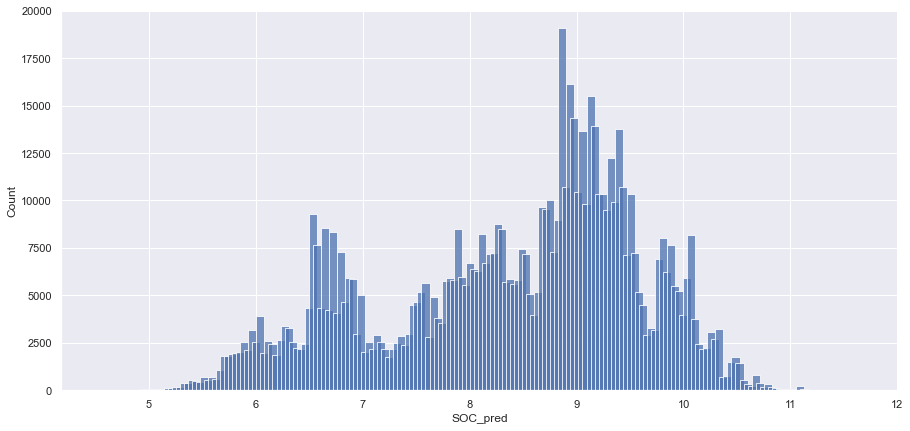

In [85]:
import seaborn as sns 
sns.histplot(x = "SOC_pred", data = source_data_pred, multiple ="stack", shrink =2) #element = step,poly
sns.set(rc={'figure.figsize':(13,7)})

In [87]:
source_data_pred.to_file('data/soc_final_rfe_newdata_nvdi_geol.shp', encoding='utf-8')

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
